# 3 - Plot

## Load all results data and compute mean & std

In [91]:
import numpy as np
import os

PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))

keys = ['correct_pairings_inv', 'correct_pairings_basX', 'spearman_inv', 'spearman_basX', 'aucs_inv', 'aucs_basX', 'spearman_exceptional_inv', 'spearman_exceptional_basX']

result_dict = {}

DATASET_NAME = 'mnist'
MODEL_NAME = '0_softmax'
GENERATION_MODE = ''

num_files = 0 # Count how many files are involved for use below

for f in os.listdir(os.path.join(PROJ_DIR, 'results')):
    if f.startswith(DATASET_NAME) and f.endswith(f'{MODEL_NAME}{GENERATION_MODE}_results.npz'):
        FILENAME = os.path.join(PROJ_DIR, 'results', f)
        num_files += 1
        with np.load(FILENAME) as data:
            for k in keys:
                d = np.expand_dims(data[k], axis=0)
                if k in result_dict:
                    result_dict[k] = np.vstack((result_dict[k], d))
                else:
                    result_dict[k] = d

for k in keys:
    result_dict[f'{k}_mean'] = np.nanmean(result_dict[k], axis=0)
    result_dict[f'{k}_std'] = np.nanstd(result_dict[k], axis=0)

# DEBUG
#print(result_dict['spearman_inv'])
#print(result_dict['spearman_inv_mean'])
#print(result_dict['spearman_basX'])
#print(result_dict['spearman_basX_mean'])

5 0.1558  |  0.0987  |  0.0448  |  0.0141  |  0.0027  |  0.0002  |  0.0000
4 0.1611  |  0.0954  |  0.0435  |  0.0153  |  0.0024  |  0.0005  |  0.0000
1 0.1641  |  0.0992  |  0.0446  |  0.0139  |  0.0010  |  0.0002  |  0.0000
3 0.1382  |  0.0840  |  0.0475  |  0.0229  |  0.0080  |  0.0013  |  0.0003
2 0.1611  |  0.1011  |  0.0449  |  0.0136  |  0.0008  |  0.0000  |  0.0000


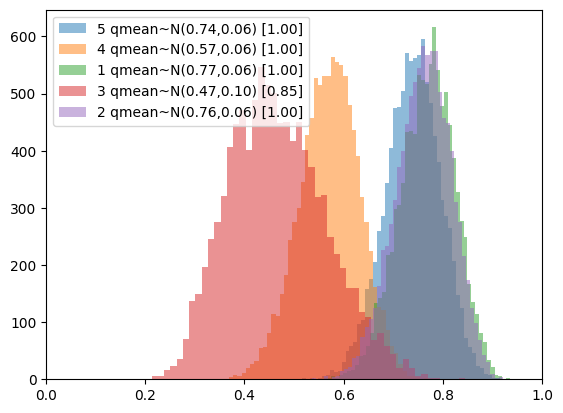

[[0.1558 0.0987 0.0448 0.0141 0.0027 0.0002 0.    ]
 [0.1611 0.0954 0.0435 0.0153 0.0024 0.0005 0.    ]
 [0.1641 0.0992 0.0446 0.0139 0.001  0.0002 0.    ]
 [0.1382 0.084  0.0475 0.0229 0.008  0.0013 0.0003]
 [0.1611 0.1011 0.0449 0.0136 0.0008 0.     0.    ]]


In [92]:
import matplotlib.pyplot as plt

boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
counts_by_sigma_level =  np.zeros((num_files, len(boundaries)))
filenames = []
qmean_means = []
qmean_stds = []

# Genetic datasets need the distribution parameters of the random datasets, so load all dataset counts
import json
DATA_PATH = os.path.join(PROJ_DIR,'assets','data')
with open(os.path.join(DATA_PATH, 'dataset-counts.json')) as fIn:
    datasets = json.load(fIn)

current_file_num = 0
for f in os.listdir(os.path.join(PROJ_DIR, 'results')):
    if f.startswith(DATASET_NAME) and f.endswith(f'{MODEL_NAME}{GENERATION_MODE}_measures.npz'):
        FILENAME = os.path.join(PROJ_DIR, 'results', f)
        filenames.append(f)
        short_filename = f.replace("_measures.npz", "").replace(DATASET_NAME, "").replace(MODEL_NAME, "").replace("_", "").replace("-", "")
        with np.load(FILENAME) as data:
            activation = data['output_curves'][8][-1]
            plt.hist(data['qmeans'],\
                    alpha = 0.5,\
                    label = f'{short_filename} qmean~N({np.mean(data["qmeans"]):.2f},{np.std(data["qmeans"]):.2f}) [{activation:.2f}]',\
                    bins = 50\
                    )
            plt.xlim(0,1)

            if GENERATION_MODE == '_genetic':
                with np.load(FILENAME.replace('_genetic', '')) as data_ref:
                    activation_ref = data_ref['output_curves'][8][-1]
                    plt.hist(data_ref['qmeans'],\
                            alpha = 0.5,\
                            label = f'{short_filename.replace("genetic", "")} qmean~N({np.mean(data_ref["qmeans"]):.2f},{np.std(data_ref["qmeans"]):.2f}) [{activation_ref:.2f}]',\
                            bins = 50\
                            )
                    plt.xlim(0,1)

            exceptional_counts = []
            # Compute z-score
            if GENERATION_MODE == '_genetic':
                qmean_mean = float(datasets[DATASET_NAME][f.replace('_genetic','')]['mean'])
                qmean_std = float(datasets[DATASET_NAME][f.replace('_genetic','')]['std'])
            else:
                qmean_mean = np.mean(data["qmeans"])
                qmean_std = np.std(data["qmeans"])
                qmean_means.append(qmean_mean)
                qmean_stds.append(qmean_std)
            
            z_scores = ((data["qmeans"] - qmean_mean) / qmean_std).flatten()

            # Count exceptional rankings
            for i in range(1,len(boundaries)+1):
                bottom_limit = boundaries[i-1]
                top_limit = float('inf')
                if i < len(boundaries):
                    top_limit = boundaries[i]
                fraction_count = np.sum(np.logical_and(bottom_limit<=z_scores, z_scores<top_limit).astype(float) / z_scores.shape[0])
                exceptional_counts.append(fraction_count)
                counts_by_sigma_level[current_file_num, i - 1] = fraction_count
            print(f'{short_filename} {"  |  ".join((map(lambda x: f"{x:.4f}", exceptional_counts)))}')
        current_file_num += 1
plt.legend()
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_qmean_dists.png'))
plt.show()

print(counts_by_sigma_level)

In [93]:
dataset_counts = {} if DATASET_NAME not in datasets else datasets[DATASET_NAME]
for i, f in enumerate(filenames):
    if GENERATION_MODE == '_genetic':
        dataset_counts[f.replace('_genetic', '')]['counts_genetic'] = list(counts_by_sigma_level[i])
    else:
        dataset_counts[f] = {'counts':list(counts_by_sigma_level[i]), 'mean': str(qmean_means[i]), 'std': str(qmean_stds[i])}

datasets[DATASET_NAME] = dataset_counts

with open(os.path.join(DATA_PATH, 'dataset-counts.json'), 'w') as fOut:
    json.dump(datasets, fOut)

In [94]:
result_dict['correct_pairings_inv_mean']

array([0.82716])

## Plot correct pairings

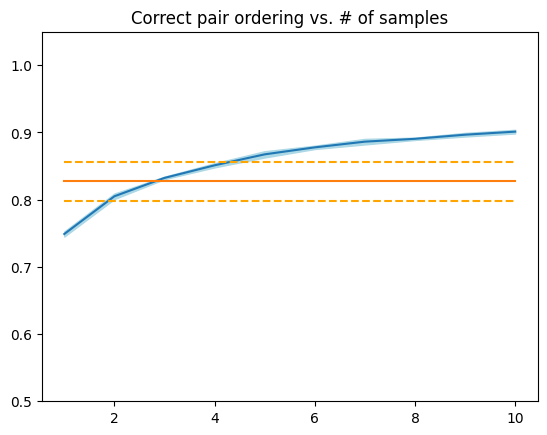

In [95]:
plt.fill_between(range(1,11), result_dict['correct_pairings_basX_mean']+result_dict['correct_pairings_basX_std'], result_dict['correct_pairings_basX_mean']-result_dict['correct_pairings_basX_std'], color='lightblue')
plt.plot(range(1,11),result_dict['correct_pairings_basX_mean'])
plt.title('Correct pair ordering vs. # of samples')
plt.plot([1,10], [result_dict['correct_pairings_inv_mean']+result_dict['correct_pairings_inv_std'], result_dict['correct_pairings_inv_mean']+result_dict['correct_pairings_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10], [result_dict['correct_pairings_inv_mean']-result_dict['correct_pairings_inv_std'], result_dict['correct_pairings_inv_mean']-result_dict['correct_pairings_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10],[result_dict['correct_pairings_inv_mean'],result_dict['correct_pairings_inv_mean']])
plt.ylim(0.5,1.05)
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_correct_pairs.png'))
plt.show()

## Plot Spearman correlation

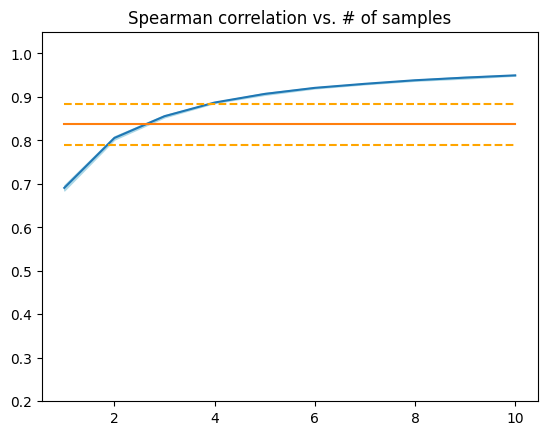

In [96]:
plt.fill_between(range(1,11), result_dict['spearman_basX_mean']+result_dict['spearman_basX_std'], result_dict['spearman_basX_mean']-result_dict['spearman_basX_std'], color='lightblue')
plt.plot(range(1,11),result_dict['spearman_basX_mean'])
plt.title('Spearman correlation vs. # of samples')
plt.plot([1,10], [result_dict['spearman_inv_mean']+result_dict['spearman_inv_std'], result_dict['spearman_inv_mean']+result_dict['spearman_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10], [result_dict['spearman_inv_mean']-result_dict['spearman_inv_std'], result_dict['spearman_inv_mean']-result_dict['spearman_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10],[result_dict['spearman_inv_mean'],result_dict['spearman_inv_mean']])
plt.ylim(0.2,1.05)
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_spearman.png'))
plt.show()

## Plot ability to detect exceptional rankings

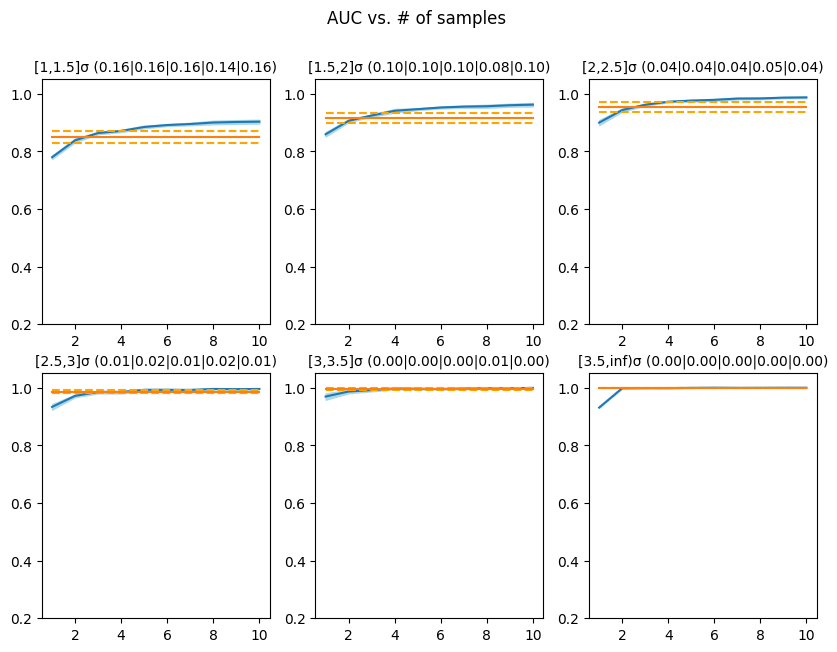

In [97]:
boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.fill_between(range(1,11), result_dict['aucs_basX_mean'][:,i+1]+result_dict['aucs_basX_std'][:,i+1], result_dict['aucs_basX_mean'][:,i+1]-result_dict['aucs_basX_std'][:,i+1], color='lightblue')
    ax.plot(range(1,11),result_dict['aucs_basX_mean'][:,i+1])
    counts_str = '|'.join(map(lambda x:f'{x:.2f}',counts_by_sigma_level[:, i]))
    if i<len(boundaries)-2:
        ax.set_title(f'[{boundaries[i+1]},{boundaries[i+1+1]}]σ ({counts_str})', fontsize=10)
    else:
        ax.set_title(f'[{boundaries[i+1]},inf)σ ({counts_str})', fontsize=10)
    ax.plot([1,10], [result_dict['aucs_inv_mean'][i+1]+result_dict['aucs_inv_std'][i+1], result_dict['aucs_inv_mean'][i+1]+result_dict['aucs_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10], [result_dict['aucs_inv_mean'][i+1]-result_dict['aucs_inv_std'][i+1], result_dict['aucs_inv_mean'][i+1]-result_dict['aucs_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10],[result_dict['aucs_inv_mean'][i+1],result_dict['aucs_inv_mean'][i+1]])
    ax.set_ylim(0.2,1.05)
plt.suptitle('AUC vs. # of samples')
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_auc_exceptional.png'))
plt.show()
plt.close(fig)

## Plot Spearman correlation for exceptional rankings

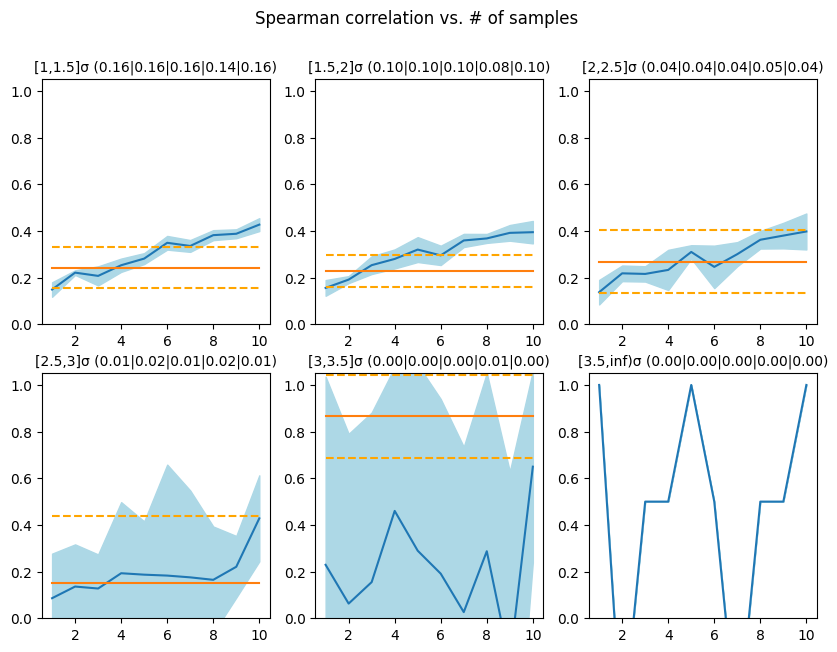

In [98]:
boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.fill_between(range(1,11), result_dict['spearman_exceptional_basX_mean'][:,i+1]+result_dict['spearman_exceptional_basX_std'][:,i+1], result_dict['spearman_exceptional_basX_mean'][:,i+1]-result_dict['spearman_exceptional_basX_std'][:,i+1], color='lightblue')
    ax.plot(range(1,11),result_dict['spearman_exceptional_basX_mean'][:,i+1])
    counts_str = '|'.join(map(lambda x:f'{x:.2f}',counts_by_sigma_level[:, i]))
    if i<len(boundaries)-2:
        ax.set_title(f'[{boundaries[i+1]},{boundaries[i+1+1]}]σ ({counts_str})', fontsize=10)
    else:
        ax.set_title(f'[{boundaries[i+1]},inf)σ ({counts_str})', fontsize=10)
    ax.plot([1,10], [result_dict['spearman_exceptional_inv_mean'][i+1]+result_dict['spearman_exceptional_inv_std'][i+1], result_dict['spearman_exceptional_inv_mean'][i+1]+result_dict['spearman_exceptional_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10], [result_dict['spearman_exceptional_inv_mean'][i+1]-result_dict['spearman_exceptional_inv_std'][i+1], result_dict['spearman_exceptional_inv_mean'][i+1]-result_dict['spearman_exceptional_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10],[result_dict['spearman_exceptional_inv_mean'][i+1],result_dict['spearman_exceptional_inv_mean'][i+1]])
    ax.set_ylim(0,1.05)
plt.suptitle('Spearman correlation vs. # of samples')
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', f'{DATASET_NAME}_{MODEL_NAME}{GENERATION_MODE}_spearman_exceptional.png'))
plt.show()